## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [4]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Schauen ob 0.5 überall besser ist oder ob selbst berechnete werte besser 
    transforms.Normalize(mean.tolist(), std.tolist()) 
    #transforms.Normalize((0.5,), (0.5,))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1723866..3.9978275].


Label: einmalige_vorfahrt


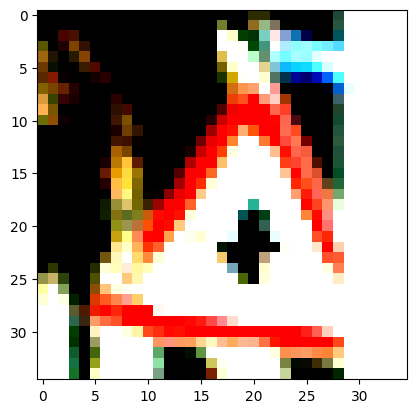

In [5]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = test_dataset[4000]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)


### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.3)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.3)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.3)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

### Different CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Erste Convolutional-Schicht mit SELU-Aktivierung und Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Zweite Convolutional-Schicht mit ReLU-Aktivierung und Batch Normalization
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Max-Pooling und zusätzliche Batch Normalization
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Dritte Convolutional-Schicht mit ReLU-Aktivierung und Batch Normalization
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Zweites Max-Pooling und Dropout
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Flatten, um die Tensoren für die Dense-Schichten vorzubereiten
        self.flatten = nn.Flatten()
        
        # Dense-Schichten mit ReLU, Batch Normalization und Dropout
        self.fc1 = nn.Linear(64 * 7 * 7, 750)  # Anpassen der Eingangsgröße an die Architektur
        self.bn5 = nn.BatchNorm1d(750)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(750, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)
        
        # Ausgabe-Schicht mit Softmax-Aktivierung
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        # Erste Convolutional-Schicht mit SELU
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Zweite Convolutional-Schicht mit ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.bn3(x))
        
        # Dritte Convolutional-Schicht mit ReLU
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Erste Dense-Schicht mit ReLU und Dropout
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)
        
        # Zweite Dense-Schicht mit ReLU und Dropout
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout3(x)
        
        # Ausgabe-Schicht mit Softmax
        x = F.softmax(self.fc3(x), dim=1)
        return x


### Gans 🦢 viele CNNs trainieren 🏋️‍♀️🏋️‍♂️
Dropout von 0,2 bis 0,6  -> gleich lassen 0,5
Learing Rate von 0.001 bis 0.01 -> 0.01 0.005 0.001 
weight_decay von 0.0001 bis 0.005 -> 0.0001 0,0007 0,001 0,005
Factor 0.1 bis 0.9 -> gleich bei 0,9
Threshold 0.0001 bis 0.1 -> 0.1 0.01 0.001


In [ ]:
# Initialisierung des Modells
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.001
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# ReduceLROnPlateau Scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001)

### Train the model in a Loop

In [21]:
def training_loop(lr, weight_decay, threshold):
    # Initialisierung des Modells
    model = CNN(num_classes).to(device)
    loss_func = nn.CrossEntropyLoss()

    # Initiale Lernrate und Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=threshold, verbose=True)
    return model, loss_func, optimizer, scheduler

In [11]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [58]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


### Test model with accuracy plot

#### Get the Activation of the Model Layers 

In [12]:
# Dictionary to store activations
activations = {}

# Hook function to capture the outputs
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialize the model
model = CNN(num_classes=43)
model.to(device)
# Initiale Lernrate und Optimizer
loss_func = nn.CrossEntropyLoss()
lr = 0.01
weight_decay = 0.001
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Register hooks to capture activations from convolutional and fully connected layers
model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

# Register hooks for ReLU activations
model.relu1.register_forward_hook(get_activation('relu1'))
model.relu2.register_forward_hook(get_activation('relu2'))
model.relu3.register_forward_hook(get_activation('relu3'))
model.relu4.register_forward_hook(get_activation('relu4'))
model.relu5.register_forward_hook(get_activation('relu5'))

# Register hooks for fully connected layers
model.fc6.register_forward_hook(get_activation('fc6'))
model.fc7.register_forward_hook(get_activation('fc7'))
model.fc8.register_forward_hook(get_activation('fc8'))
model.fc9.register_forward_hook(get_activation('fc9'))

# Register hooks for ReLU activations in fully connected layers
model.relu6.register_forward_hook(get_activation('relu6'))
model.relu7.register_forward_hook(get_activation('relu7'))
model.relu8.register_forward_hook(get_activation('relu8'))


Epoch 1/20
Training Loss: 3.7329
Training Accuracy: 8.55%
Test Accuracy: 8.97%


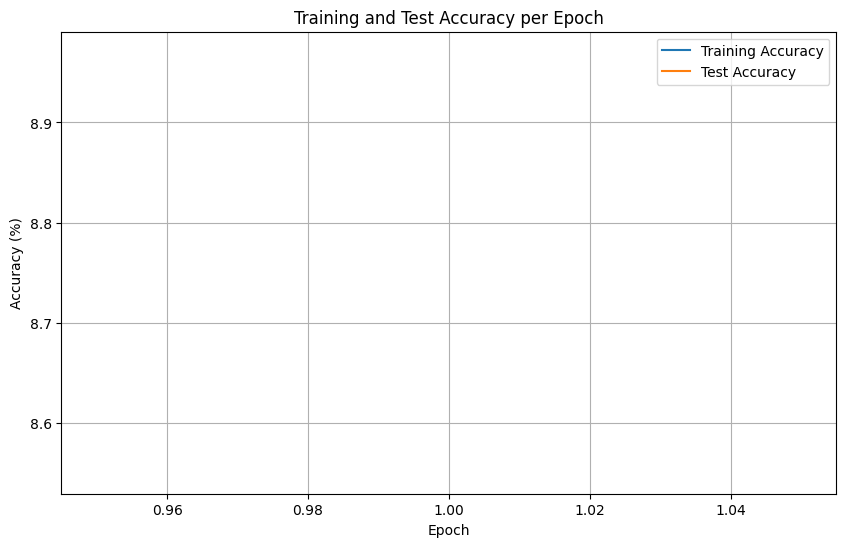

Epoch 2/20
Training Loss: 3.6713
Training Accuracy: 6.64%
Test Accuracy: 6.43%


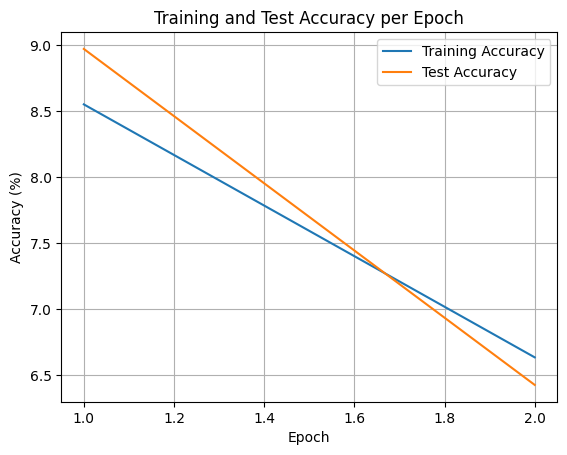

Epoch 3/20
Training Loss: 3.5320
Training Accuracy: 6.64%
Test Accuracy: 6.43%


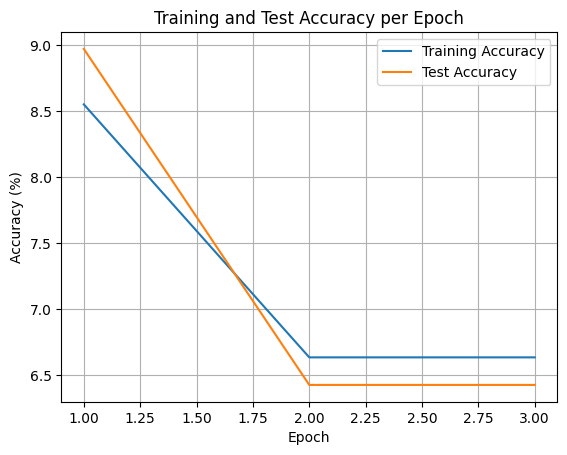

Epoch 4/20
Training Loss: 3.4640
Training Accuracy: 7.13%
Test Accuracy: 6.25%


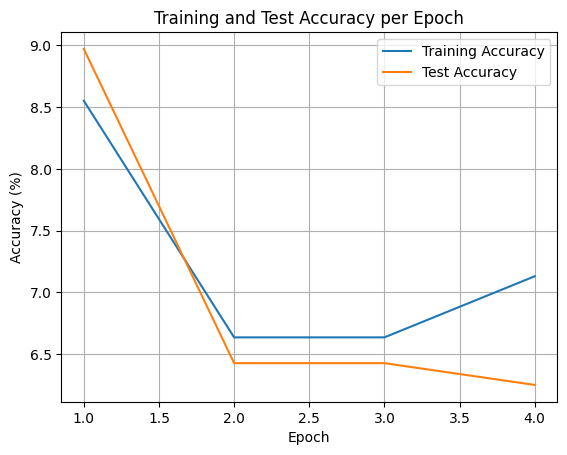

Epoch 5/20
Training Loss: 3.4047
Training Accuracy: 7.11%
Test Accuracy: 6.16%


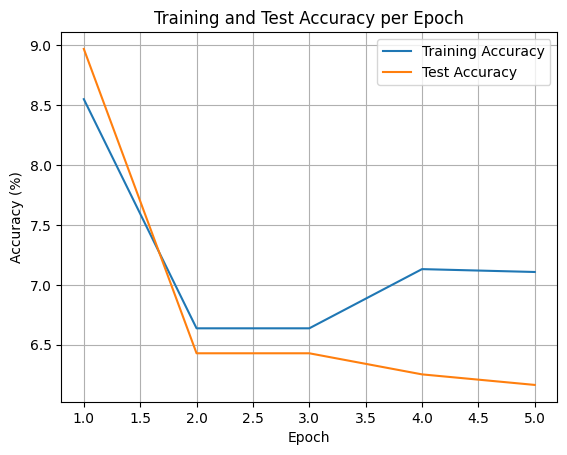

Epoch 6/20
Training Loss: 3.3147
Training Accuracy: 8.41%
Test Accuracy: 6.84%


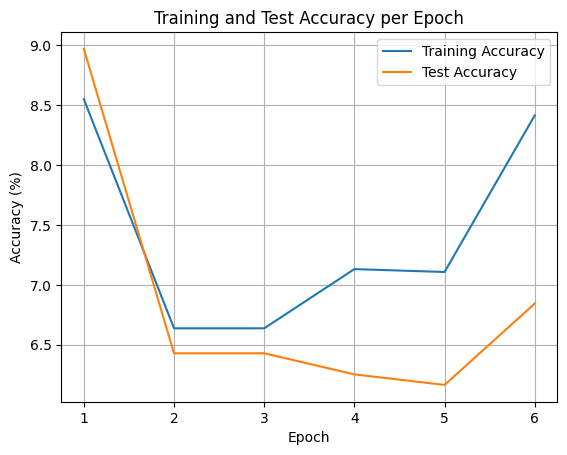

Epoch 7/20
Training Loss: 3.2000
Training Accuracy: 13.29%
Test Accuracy: 13.17%


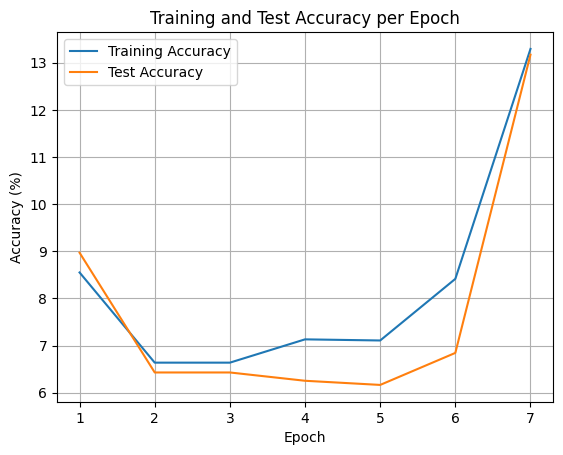

Epoch 8/20
Training Loss: 3.1039
Training Accuracy: 15.56%
Test Accuracy: 16.82%


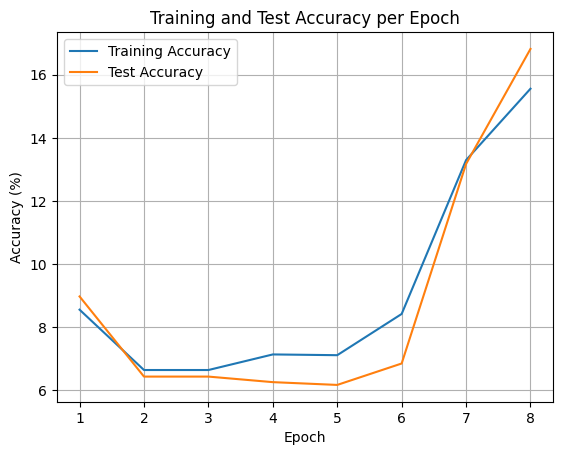

Epoch 9/20
Training Loss: 3.0180
Training Accuracy: 16.17%
Test Accuracy: 15.74%


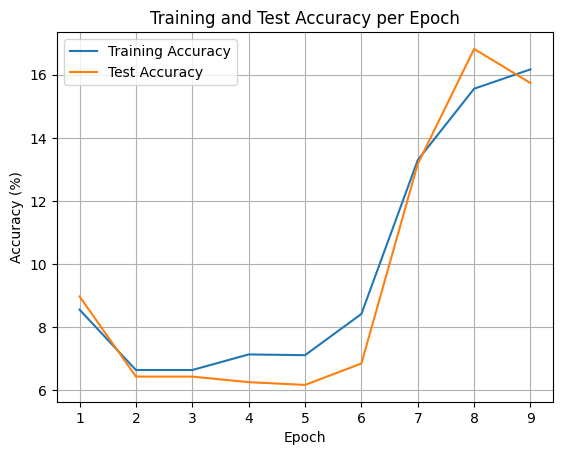

Epoch 10/20
Training Loss: 2.8882
Training Accuracy: 19.39%
Test Accuracy: 17.41%


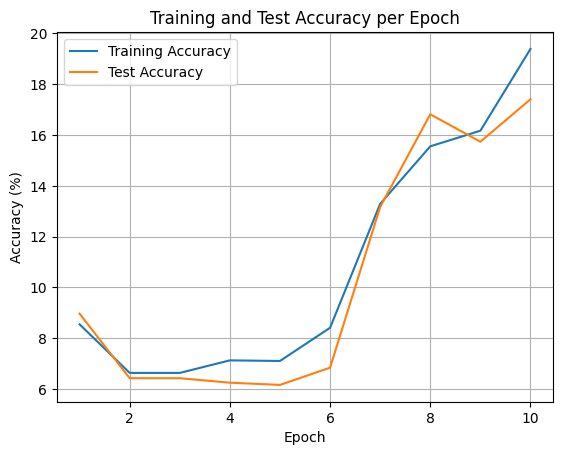

Epoch 11/20
Training Loss: 2.6881
Training Accuracy: 25.07%
Test Accuracy: 26.29%


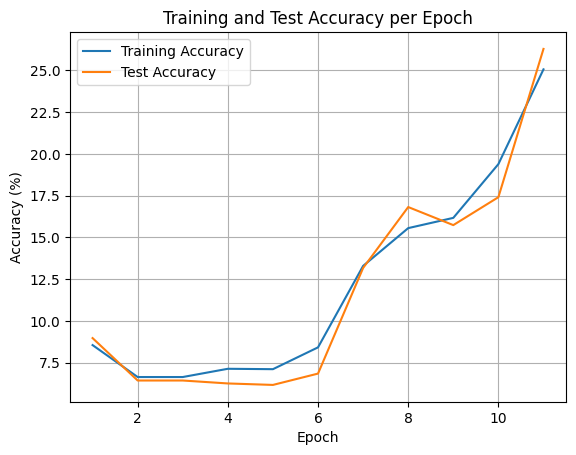

Epoch 12/20
Training Loss: 2.4410
Training Accuracy: 28.07%
Test Accuracy: 27.80%


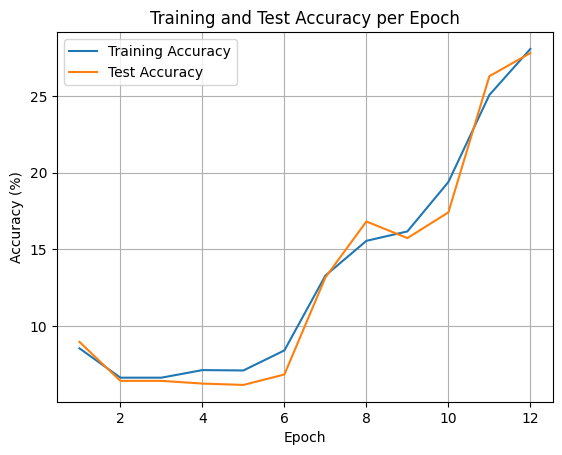

Epoch 13/20
Training Loss: 2.1672
Training Accuracy: 40.19%
Test Accuracy: 37.85%


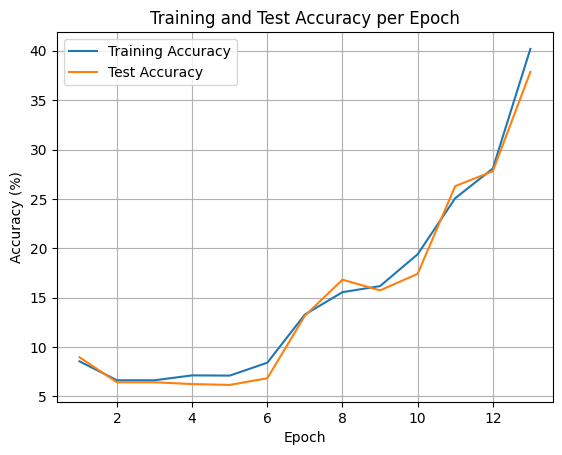

Epoch 14/20
Training Loss: 1.8236
Training Accuracy: 37.00%
Test Accuracy: 30.97%


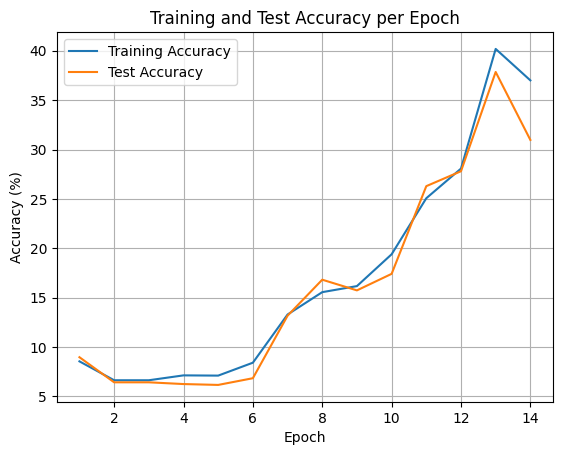

Epoch 15/20
Training Loss: 1.5279
Training Accuracy: 59.25%
Test Accuracy: 54.79%


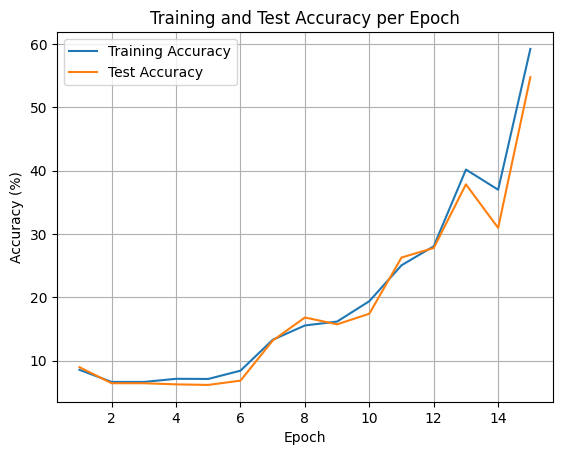

Epoch 16/20
Training Loss: 1.2383
Training Accuracy: 70.27%
Test Accuracy: 65.15%


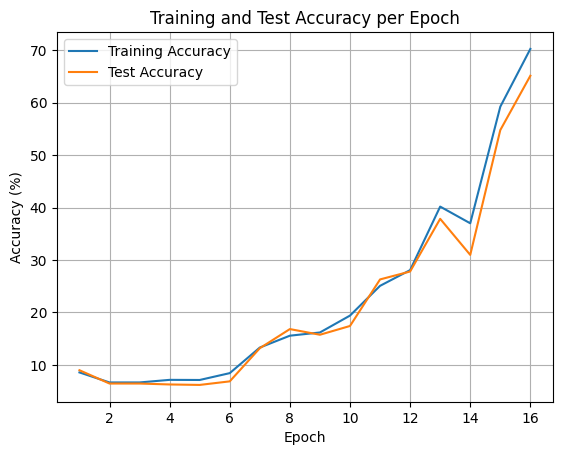

Epoch 17/20
Training Loss: 0.9889
Training Accuracy: 76.45%
Test Accuracy: 74.88%


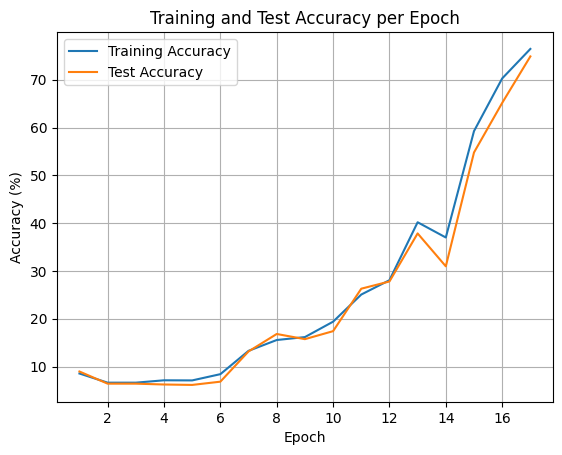

Epoch 18/20
Training Loss: 0.8027
Training Accuracy: 80.99%
Test Accuracy: 76.81%


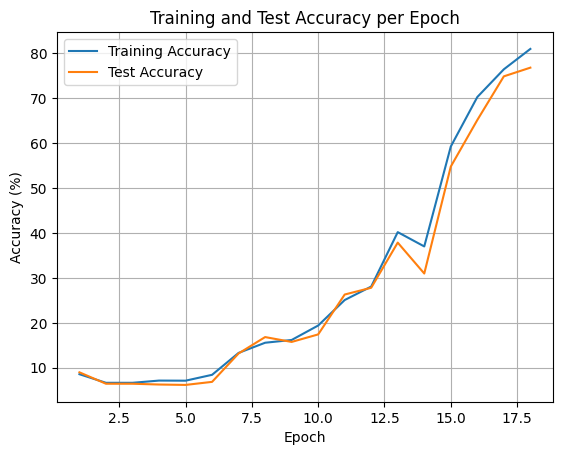

Epoch 19/20
Training Loss: 0.6445
Training Accuracy: 85.66%
Test Accuracy: 80.19%


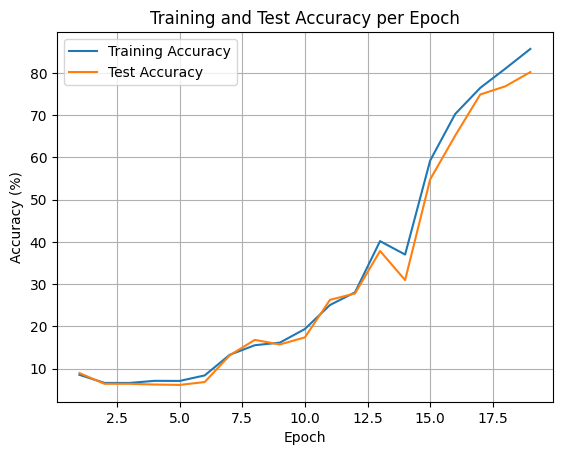

Epoch 20/20
Training Loss: 0.5316
Training Accuracy: 89.07%
Test Accuracy: 82.63%


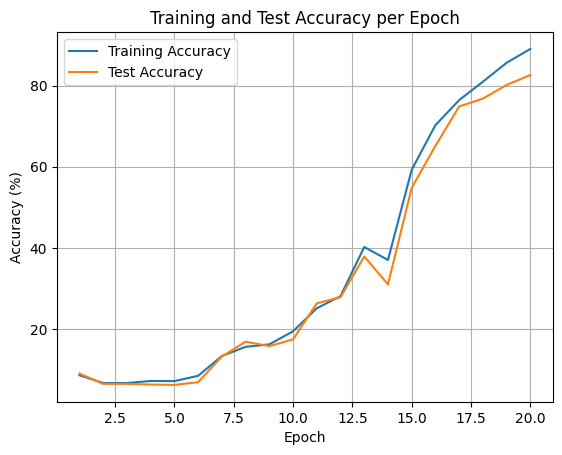

In [13]:
num_epochs = 20
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plot
plt.figure(figsize=(10, 6))

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(train_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    #current_lr =  scheduler.get_last_lr()
    #print(f"Learning Rate: {current_lr}")
    
    
    # Step the scheduler to adjust learning rate based on validation loss (or training loss)
    #scheduler.step(avg_loss)

    # Clear the current plot and update with new data
    plt.clf()  # Clear the figure
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Display the updated plot
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

# Show the final plot after all epochs
plt.show()

# Run Test For Loop

In [46]:
def mode_train(lr, weight_decay, threshold):
    # Training starten (Stellen Sie sicher, dass die Funktion training_loop richtig definiert ist)
    model, loss_func, optimizer, scheduler = training_loop(lr, weight_decay, threshold)
    print("----------------------------------------")
    print(f"Start training the model with:\n lr: {lr} \n weight_decay: {weight_decay} \n threshold: {threshold}")
    print("----------------------------------------")
    num_epochs = 80
    train_accuracies = []
    test_accuracies = []
    train_losses = []

    # Initialisiere das Plot
    plt.figure(figsize=(10, 6))

    # Ordner für gespeicherte Modelle und Bilder erstellen, falls nicht vorhanden
    os.makedirs('img', exist_ok=True)
    os.makedirs('model', exist_ok=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0  # Verfolge den Verlust für die aktuelle Epoche

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Lösche die vorherigen Gradienten
            outputs = model(images)  # Vorwärtsdurchlauf
            loss = loss_func(outputs, labels)  # Verlust berechnen
            loss.backward()  # Rückwärtsdurchlauf
            optimizer.step()  # Gewicht anpassen
            
            running_loss += loss.item()  # Verlust akkumulieren

        # Durchschnittlichen Verlust für die aktuelle Epoche berechnen
        avg_loss = running_loss / len(train_loader)

        # Genauigkeit auf Trainings- und Testdaten berechnen
        train_accuracy = calculate_accuracy(model, train_loader, device)
        test_accuracy = calculate_accuracy(model, test_loader, device)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(avg_loss)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        current_lr = scheduler.get_last_lr()
        print(f"Learning Rate: {current_lr}")
        
        # Den Scheduler nach dem Training der aktuellen Epoche anpassen
        scheduler.step(avg_loss)

        # Plot mit den aktuellen Daten aktualisieren
        plt.clf()  # Figur löschen
        plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'LR: {lr}, WD: {weight_decay}, Th: {threshold} - Training and Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        if(epoch == num_epochs -1):
            # Speicher den Plot im 'img' Ordner mit dem entsprechenden Dateinamen
            plot_filename = f'img/plot_lr_{lr}_wd_{weight_decay}_th_{threshold}.png'
            plt.savefig(plot_filename)
        
        # Zeige den aktualisierten Plot
        plt.pause(0.1)

    # Speicher das Modell im 'model' Ordner mit dem entsprechenden Dateinamen
    model_filename = f'model/model_lr_{lr}_wd_{weight_decay}_th_{threshold}.pth'
    torch.save(model.state_dict(), model_filename)

    # Zeige das finale Plot nach allen Epochen
    plt.show()

In [ ]:
# Definiere die Hyperparameter-Werte
learning_rates = [0.01, 0.005, 0.001]
weight_decays = [0.0001, 0.0007, 0.001, 0.005]
thresholds = [0.1, 0.01, 0.001]

# Schleife über alle Kombinationen
for lr in learning_rates:
    for wd in weight_decays:
        for th in thresholds:
            # Rufe die Mode_train Funktion mit den aktuellen Hyperparametern auf
            mode_train(lr, wd, th)

### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [46]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 3.7104, Val-loss: 3.6906, Val-acc: 6.6%
Epoch [2/50], Loss: 3.6441, Val-loss: 3.4800, Val-acc: 6.3%
Epoch [3/50], Loss: 3.3963, Val-loss: 3.4482, Val-acc: 6.4%
Epoch [4/50], Loss: 3.3348, Val-loss: 3.3849, Val-acc: 9.7%
Epoch [5/50], Loss: 3.2094, Val-loss: 3.2500, Val-acc: 9.6%
Epoch [6/50], Loss: 3.1779, Val-loss: 3.1397, Val-acc: 15.6%
Epoch [7/50], Loss: 3.0509, Val-loss: 3.0311, Val-acc: 16.1%
Epoch [8/50], Loss: 2.5950, Val-loss: 2.6115, Val-acc: 24.5%
Epoch [9/50], Loss: 2.3712, Val-loss: 2.0363, Val-acc: 35.5%
Epoch [10/50], Loss: 1.8296, Val-loss: 1.5900, Val-acc: 48.1%
Epoch [11/50], Loss: 1.3498, Val-loss: 1.3335, Val-acc: 56.0%
Epoch [12/50], Loss: 1.0220, Val-loss: 1.0275, Val-acc: 66.1%
Epoch [13/50], Loss: 1.0088, Val-loss: 0.8748, Val-acc: 70.2%
Epoch [14/50], Loss: 0.8578, Val-loss: 0.6781, Val-acc: 79.2%
Epoch [15/50], Loss: 0.7416, Val-loss: 0.5881, Val-acc: 80.3%
Epoch [16/50], Loss: 0.4649, Val-loss: 0.5519, Val-acc: 84.2%
Epoch [17/50], Loss: 0

# Test the Model

### Test the current Model

In [60]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

#torch.save(model.state_dict(), "model/good_models/99_95_and_95_77/training_99_95_test_95_77.pth")


Accuracy on training data: 0.75%
Accuracy on test data: 0.82%


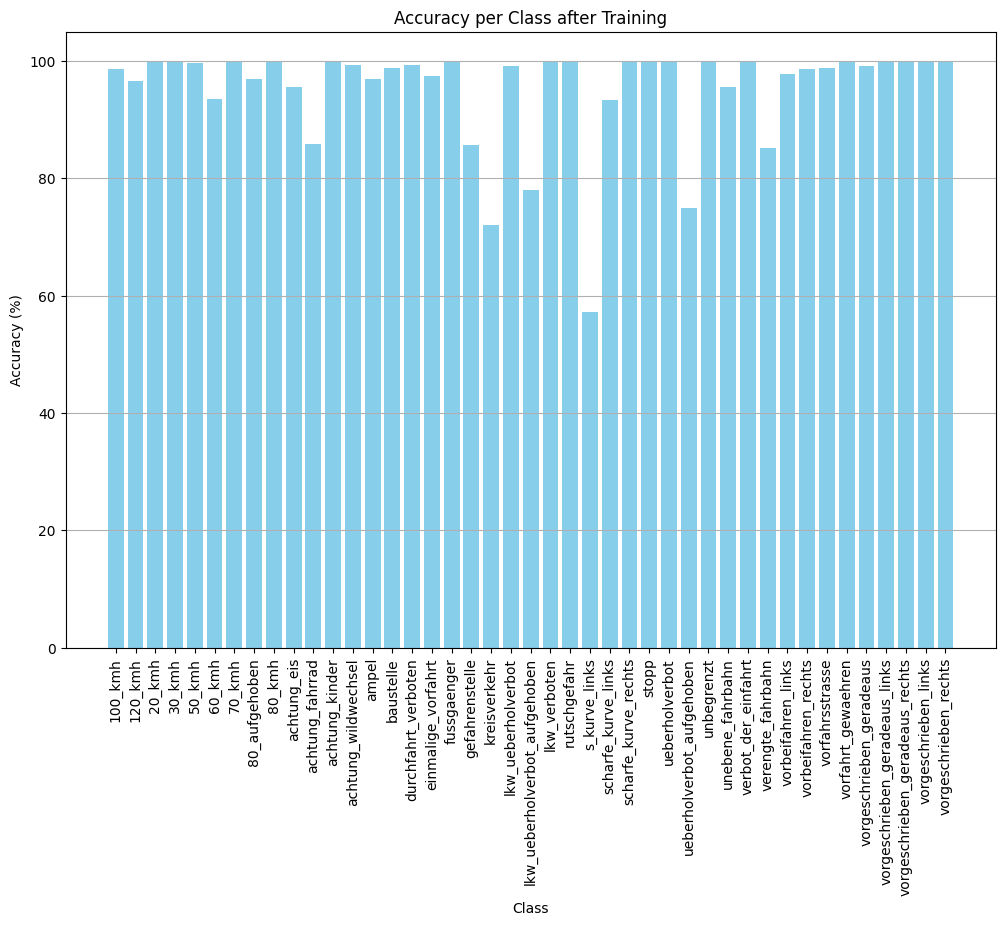

In [36]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


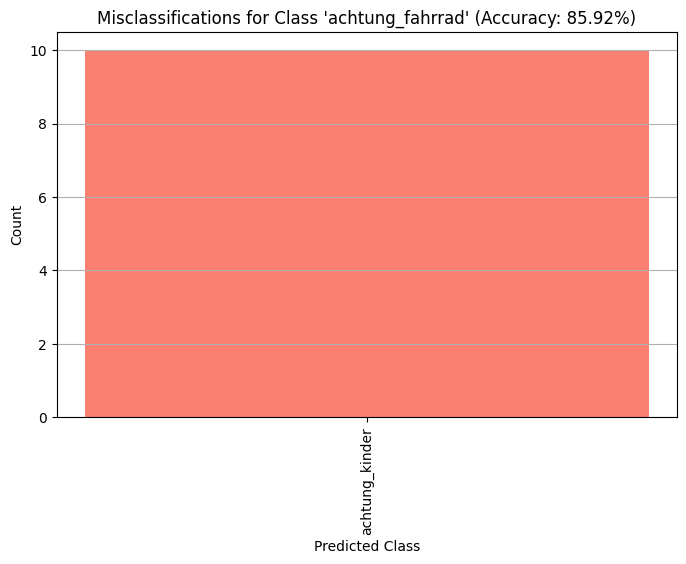

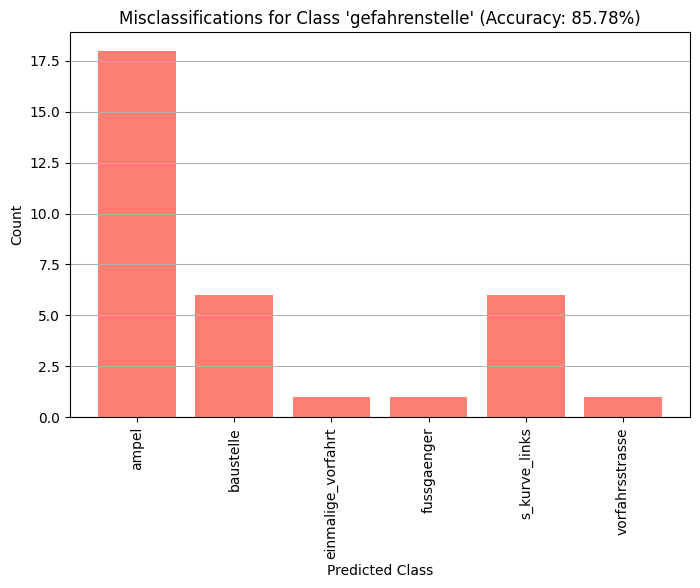

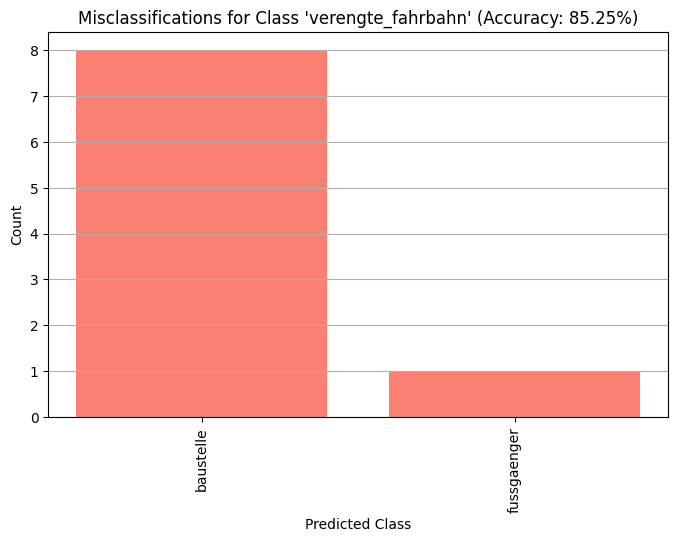

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 90:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [12]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
 
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
 
        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()
 
        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()
 
        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
 
        self.dropout6 = nn.Dropout(p=0.5)
 
 
        self.fc6 = nn.Linear(128, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()
 
        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()
 
 
        self.fc9 = nn.Linear(128, num_classes)
 
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
 
        out = self.conv_layer3(out)
        out = self.relu3(out)
 
        out = self.conv_layer4(out)
        out = self.relu4(out)
 
        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
 
        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)
 
        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)
 
        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)
 
        out = self.fc9(out)
 
        return out

Provide now informations such as path and the number of output classes

In [13]:
model_path = 'model/good_models/99_95_and_95_77/training_99_95_test_95_77.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")
 
# Modell laden
trained_model = Net(num_classes=43)
trained_model.load_state_dict(torch.load(model_path))

C:\Users\v814u63\AppData\Local\Temp\ipykernel_22592\3024345232.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Now you can test your new model

In [19]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 99.95%


KeyboardInterrupt: 

# Visualisation and Explainable Part 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8684449..3.9978275].


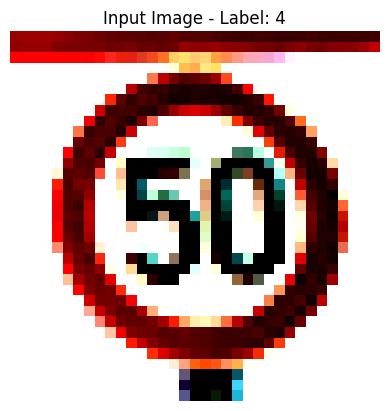

In [44]:
# Get a batch of test images
images, labels = next(iter(test_loader))

# Select a random or specific image by changing the index
rand = 9  # Ändere die Zahl hier, um ein anderes Bild anzuzeigen
image = images[rand:rand+1]
label = labels[rand]
image = image.to(device)
label = label.to(device)

# Display the input image
plt.imshow(image[0].permute(1, 2, 0).cpu())  # Bild vom Tensor in NumPy-Format umwandeln
plt.title(f'Input Image - Label: {label.item()}')
plt.axis('off')
plt.show()


In [45]:
# Reset the activations dictionary
activations = {}
# Ensure hooks are registered (they should be from earlier)
# Run the model on the sample image
output = model(image)
print(activations)


{'conv_layer1': tensor([[[[-0.1634, -0.5212, -0.4766,  ..., -0.5617, -0.7500, -0.9280],
          [-0.2520,  0.0418, -0.0335,  ..., -0.6817, -0.9224,  0.1800],
          [-2.0197, -0.5877, -0.6560,  ..., -1.0154, -1.2222,  2.2692],
          ...,
          [-4.3664, -0.0948, -0.0948,  ..., -0.0166,  0.0088,  6.0647],
          [-4.3664, -0.0948, -0.0948,  ..., -0.0079,  0.0312,  6.0319],
          [-2.0104,  0.8187,  0.8187,  ...,  0.7275,  0.7006,  5.9586]],

         [[-0.7002, -0.1409, -0.1530,  ..., -0.3299, -0.2361, -0.5080],
          [-0.5428, -0.4221, -0.4256,  ..., -0.8754, -0.7432, -1.6332],
          [ 0.2911, -0.8226, -0.7658,  ..., -0.2331, -0.0681, -1.8983],
          ...,
          [ 3.8479, -0.5226, -0.5226,  ..., -0.5208, -0.5414, -3.4420],
          [ 3.8479, -0.5226, -0.5226,  ..., -0.5288, -0.5488, -3.4083],
          [ 3.4346,  0.2125,  0.2125,  ...,  0.1452,  0.1487, -1.9141]],

         [[ 0.1039, -0.5560, -0.5767,  ..., -0.9961, -0.9250, -1.5511],
          [-0.

Shape of conv1 activations: torch.Size([1, 64, 34, 34])


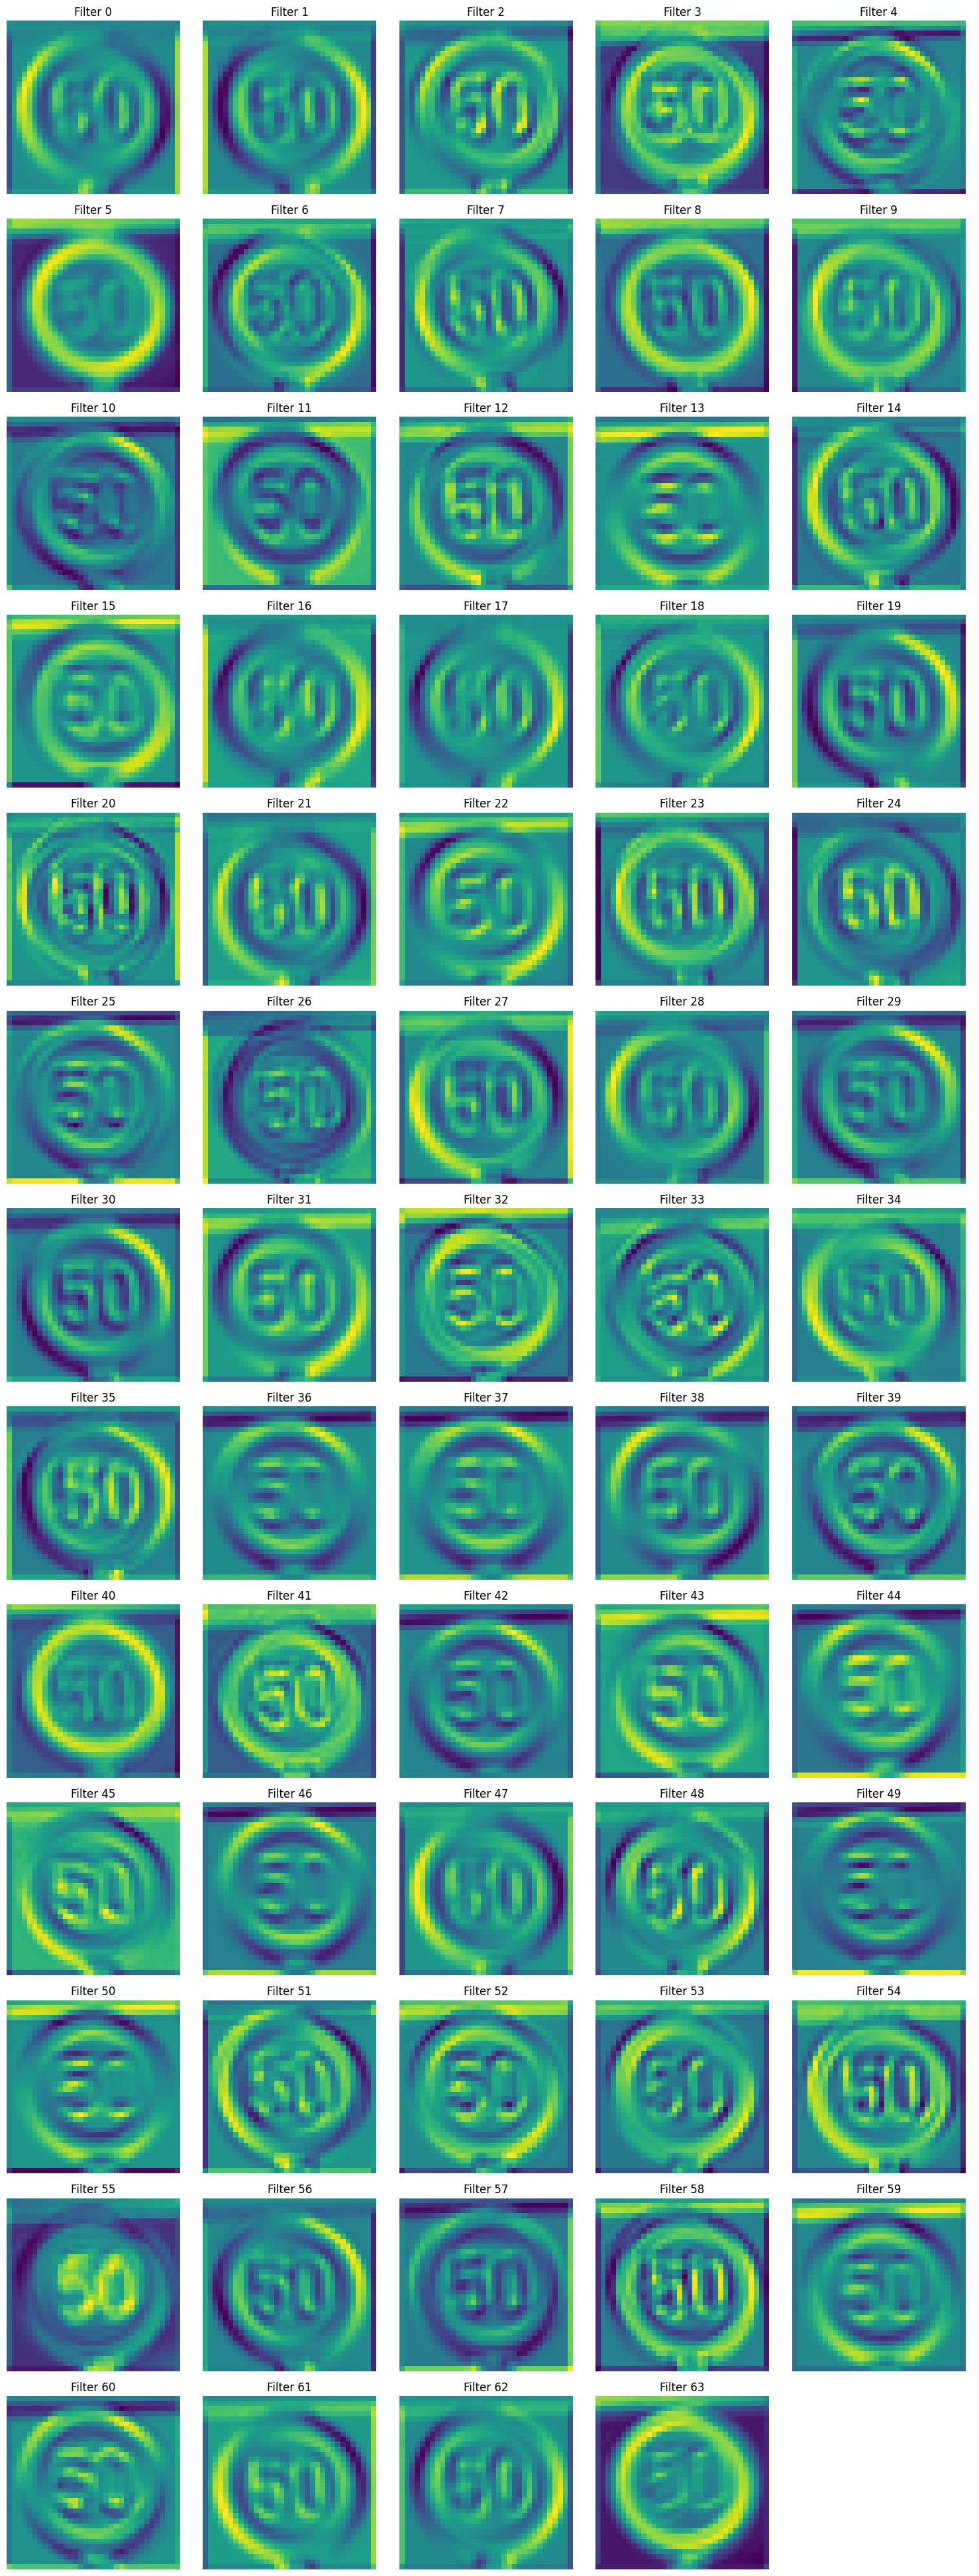

In [46]:
import math
import matplotlib.pyplot as plt

# Aktivierungen abrufen
act = activations['conv_layer1']
print(f"Shape of conv1 activations: {act.shape}")

# Filter-Anzahl
num_filters = act.shape[1]

# Dynamische Subplots
rows = math.ceil(num_filters / 5)
fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))

for idx in range(num_filters):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(act[0, idx].detach().cpu(), cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

# Unbenutzte Subplots entfernen (falls nötig)
for idx in range(num_filters, rows * 5):
    row = idx // 5
    col = idx % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### Activation Maximazation

In [47]:
def activation_maximization(model, layer_name, filter_index, input_size=(1, 3, 35, 35), lr=0.1, iterations=30):
    device = next(model.parameters()).device  # Gerät des Modells (CPU oder GPU)
    
    # Initialisierung der Eingabe
    input_image = torch.randn(input_size, requires_grad=True, device=device)  # Auf das richtige Gerät legen
    
    optimizer = optim.Adam([input_image], lr=lr, weight_decay=1e-6)
    activations = {}

    # Hook-Funktion für die gewünschte Schicht
    def hook_function(module, input, output):
        activations[layer_name] = output

    # Hook registrieren
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_function)

    for i in range(iterations):
        optimizer.zero_grad()
        model(input_image)  # Modell auf dem richtigen Gerät ausführen
        act = activations[layer_name][0, filter_index]
        loss = -torch.mean(act)  # Aktivierung maximieren
        loss.backward()
        optimizer.step()
        # Eingabewerte beschränken
        input_image.data = torch.clamp(input_image.data, 0, 1)
        if (i + 1) % 10 == 0:
            print(f"Iteration {i+1}/{iterations}, Loss: {-loss.item():.4f}")

    hook.remove()
    return input_image.detach()



Generating image for relu1 filter 0
Iteration 10/30, Loss: 0.5080
Iteration 20/30, Loss: 0.6118
Iteration 30/30, Loss: 0.6292

Generating image for relu1 filter 1
Iteration 10/30, Loss: 0.2026
Iteration 20/30, Loss: 0.2467
Iteration 30/30, Loss: 0.2611

Generating image for relu1 filter 2
Iteration 10/30, Loss: 0.3585
Iteration 20/30, Loss: 0.4465
Iteration 30/30, Loss: 0.4604

Generating image for relu1 filter 3
Iteration 10/30, Loss: 0.3077
Iteration 20/30, Loss: 0.4684
Iteration 30/30, Loss: 0.4843

Generating image for relu1 filter 4
Iteration 10/30, Loss: 0.1926
Iteration 20/30, Loss: 0.2271
Iteration 30/30, Loss: 0.2326

Generating image for relu1 filter 5
Iteration 10/30, Loss: 0.5911
Iteration 20/30, Loss: 0.9136
Iteration 30/30, Loss: 0.9145

Generating image for relu1 filter 6
Iteration 10/30, Loss: 0.3846
Iteration 20/30, Loss: 0.5164
Iteration 30/30, Loss: 0.5495

Generating image for relu1 filter 7
Iteration 10/30, Loss: 0.3909
Iteration 20/30, Loss: 0.4522
Iteration 30/3

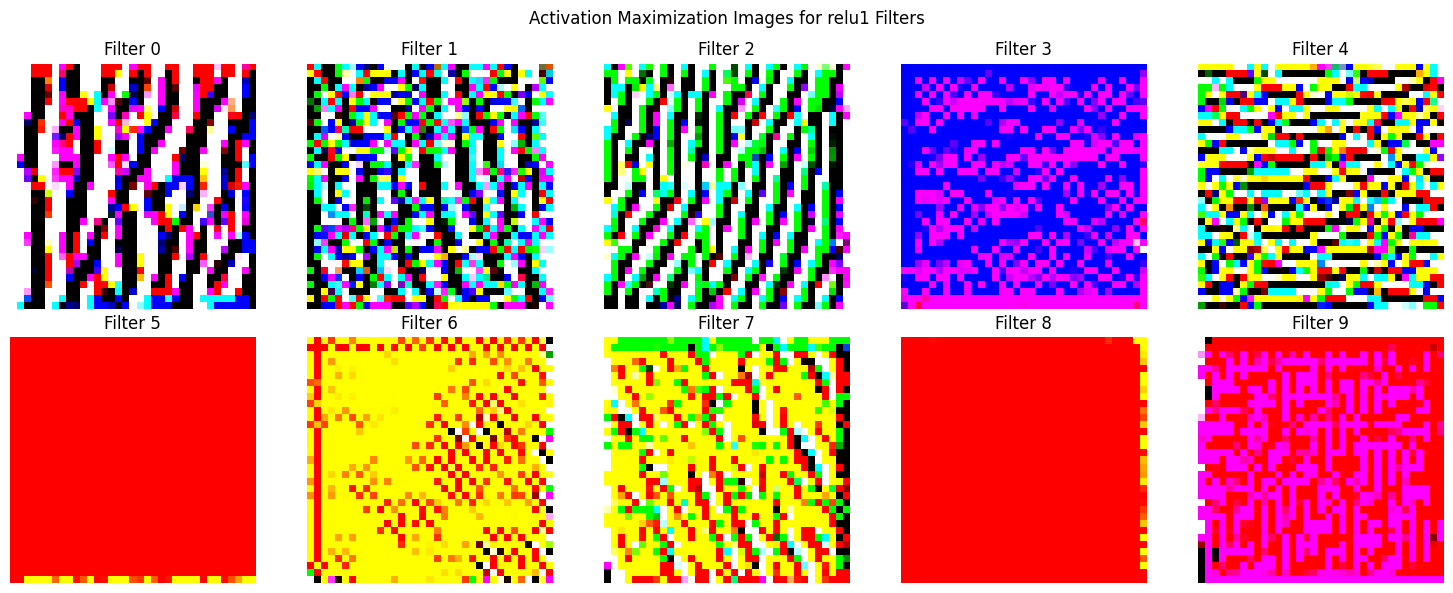

In [48]:
conv_layer1num_filters_relu1 = model.conv_layer1.out_channels
am_images_relu1 = []

for filter_idx in range(conv_layer1num_filters_relu1):
    print(f"\nGenerating image for relu1 filter {filter_idx}")
    am_image = activation_maximization(model, 'relu1', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30)
    am_images_relu1.append(am_image)

print("\nCompleted activation maximization for relu1.")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, am_image in enumerate(am_images_relu1[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild darstellen
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu1 Filters')
plt.tight_layout()
plt.show()



Generating image for relu2 filter 0
Iteration 10/30, Loss: 0.1430
Iteration 20/30, Loss: 0.2605
Iteration 30/30, Loss: 0.3032

Generating image for relu2 filter 1
Iteration 10/30, Loss: 0.0001
Iteration 20/30, Loss: 0.2960
Iteration 30/30, Loss: 0.5138

Generating image for relu2 filter 2
Iteration 10/30, Loss: 0.4923
Iteration 20/30, Loss: 0.7410
Iteration 30/30, Loss: 0.8199

Generating image for relu2 filter 3
Iteration 10/30, Loss: 0.1079
Iteration 20/30, Loss: 0.2720
Iteration 30/30, Loss: 0.3280

Generating image for relu2 filter 4
Iteration 10/30, Loss: 0.0335
Iteration 20/30, Loss: 0.0644
Iteration 30/30, Loss: 0.0930

Generating image for relu2 filter 5
Iteration 10/30, Loss: 0.0632
Iteration 20/30, Loss: 0.2032
Iteration 30/30, Loss: 0.3227

Generating image for relu2 filter 6
Iteration 10/30, Loss: 0.5143
Iteration 20/30, Loss: 0.7049
Iteration 30/30, Loss: 0.7614

Generating image for relu2 filter 7
Iteration 10/30, Loss: 0.0023
Iteration 20/30, Loss: 0.0697
Iteration 30/3

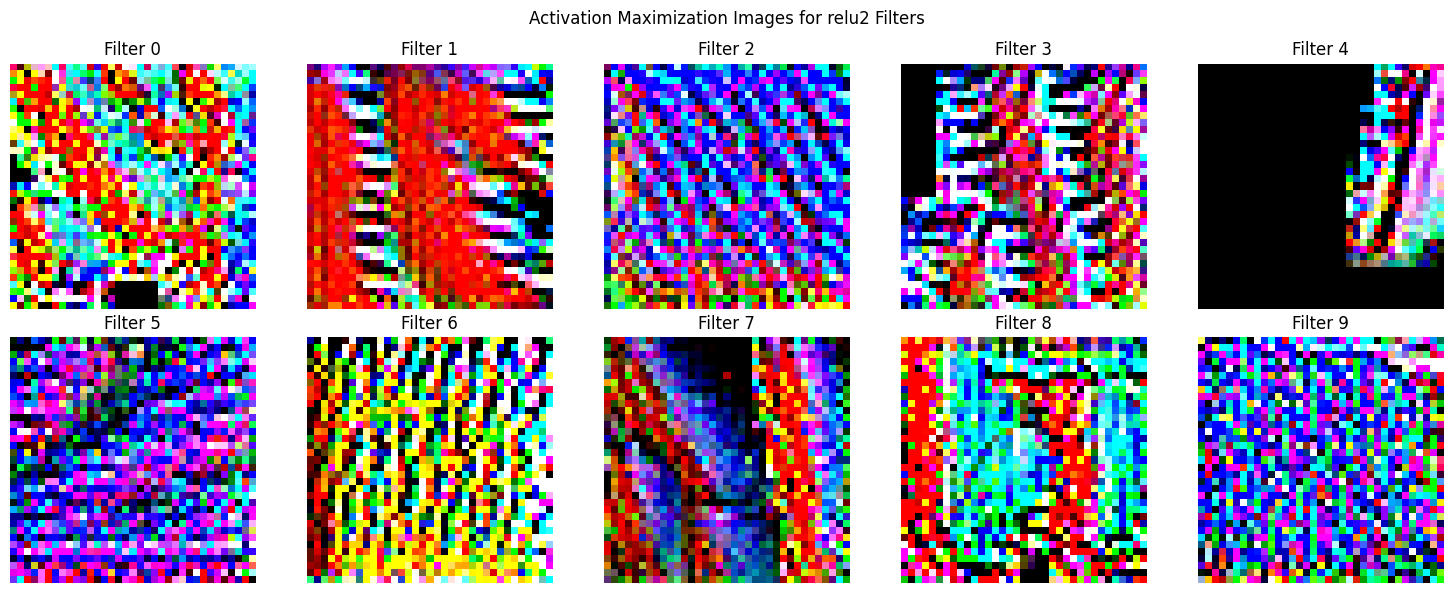

In [49]:
# ReLu 2

# Anzahl der Filter in der zweiten Schicht (ReLU2)
conv_layer2num_filters_relu2 = model.conv_layer2.out_channels
am_images_relu2 = []

# Aktivierungsmaximierung für alle Filter der ReLU2-Schicht
for filter_idx in range(conv_layer2num_filters_relu2):
    print(f"\nGenerating image for relu2 filter {filter_idx}")
    am_image = activation_maximization(
        model, 'relu2', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30
    )
    am_images_relu2.append(am_image)

print("\nCompleted activation maximization for relu2.")

# Darstellung der Ergebnisse
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Layout für 10 Filter

for idx, am_image in enumerate(am_images_relu2[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu2 Filters')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1723866..3.9978275].


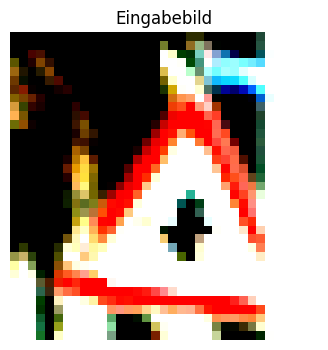

Shape der Aktivierung nach ReLU2: torch.Size([192, 15, 15])


ValueError: cannot reshape array of size 15 into shape (35,35)

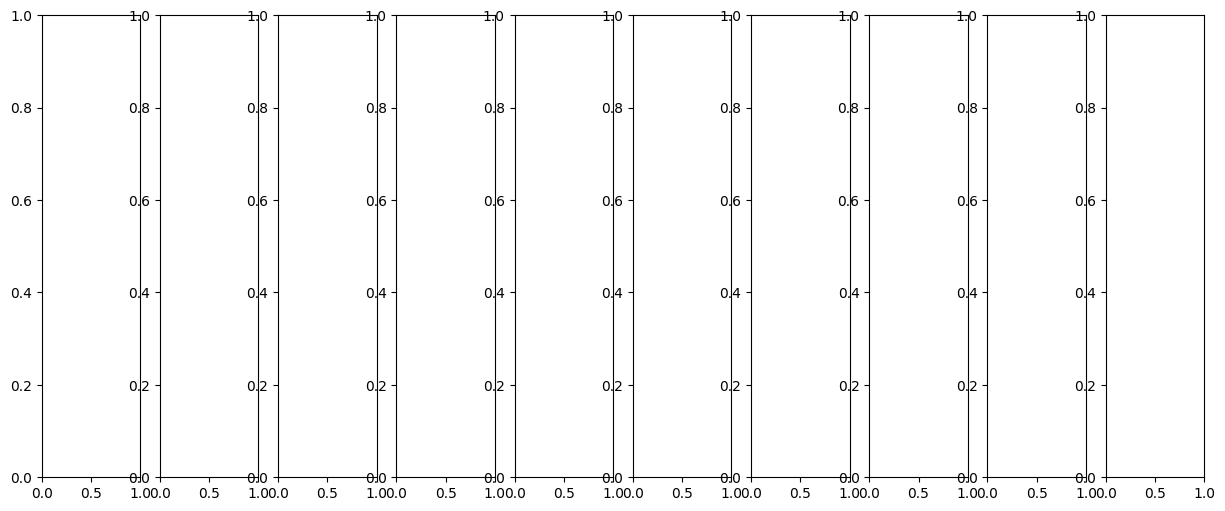

In [50]:
import torch
import matplotlib.pyplot as plt

# Dummy-Eingabebild erstellen (RGB-Bild, normalisiert zwischen 0 und 1) und auf das Gerät verschieben
img, label = test_dataset[4000]  # Zufälliges Bild (Channels, Height, Width)
input_image = img.to(device)  # Die Variable `img` sollte `input_image` zugewiesen werden.

# Weiterleitung durch die Schichten bis ReLU2
with torch.no_grad():
    out_conv1 = model.relu1(model.conv_layer1(input_image))  # Erste Schicht + ReLU
    out_pool1 = model.max_pool1(out_conv1)                  # Max-Pooling
    out_conv2 = model.relu2(model.conv_layer2(out_pool1))   # Zweite Schicht + ReLU

# Eingabebild visualisieren
plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0).cpu())  # (C, H, W) -> (H, W, C) und auf CPU für die Darstellung
plt.axis('off')
plt.title("Eingabebild")
plt.show()

# Ausgabe-Shape der Aktivierung
print("Shape der Aktivierung nach ReLU2:", out_conv2.shape)

# Aktivierungskarten der ersten 10 Filter visualisieren
num_filters = min(10, out_conv2.shape[1])  # Zeige maximal 10 Filter
fig, axes = plt.subplots(1, num_filters, figsize=(15, 6))

for i in range(num_filters):
    activation_map = out_conv2[0, i].cpu().numpy()  # Aktivierung für Filter i
    
    # Falls die Aktivierungskarten 1D sind, reshape sie zu 2D (H, W)
    if activation_map.ndim == 1:
        activation_map = activation_map.reshape(35, 35)  # Beispiel für die Größe 35x35 (oder was du benötigst)
    
    axes[i].imshow(activation_map, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}')

plt.suptitle("Aktivierungskarten für ReLU2 (bestimmtes Bild)")
plt.tight_layout()
plt.show()
